In [1]:
import torch
import numpy as np
from torch import nn
from skimage.io import imshow
import matplotlib.pyplot as plt
from skimage.io import imshow
%matplotlib inline

In [2]:
import matplotlib

from interpolation import two_point_interpolation, n_point_interpolation, \
    vicinity_sampling, analogies, gaussian_interpolation

In [3]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
)

In [4]:
def plot_torch_picture(tensor, ax=None):
   # print('tensor shape {}'.format(tensor.size()))
    tensor_to_print = (tensor + 1) / 2
    tensor_to_print = (tensor_to_print * 255).int()
    if ax is None:
#         print(tensor_to_print.squeeze(0).detach().permute(1,2,0))
        plt.imshow(tensor_to_print.squeeze(0).detach().permute(1,2,0).data.numpy())
        plt.axis('off')
        plt.show()
    else:
        ax.axis('off')
#         print(tensor_to_print.squeeze(0).detach().permute(1,2,0).data.numpy())
        ax.imshow(tensor_to_print.squeeze(0).detach().permute(1,2,0).data.numpy())

In [5]:
def draw_interpolation(tensor1, tensor2, n_steps=10, ax=None, do_scale=True):
    ts = torch.linspace(0, 1, steps=n_steps)
    for t in ts:
        yield two_point_interpolation(tensor1, tensor2, t=t, do_scale=do_scale)

In [6]:
ngpu = 1
nz = 100
ngf = 64
ndf = 64
nc = 3

In [7]:
netG = Generator(ngpu=ngpu).to('cpu')
netG.load_state_dict(torch.load('CelebA/netG_epoch_24.pth', map_location='cpu'))
netG.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

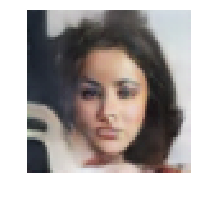

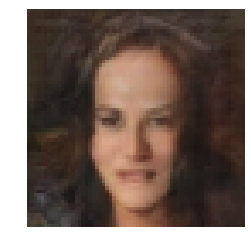

In [8]:
ax = plt.figure(figsize=(3,3)).gca()
rand = torch.randn(1, 100, 1, 1, device='cpu')
rand2 = torch.randn(1, 100, 1, 1, device='cpu')
plot_torch_picture(netG.main(rand))
plot_torch_picture(netG.main(rand2))

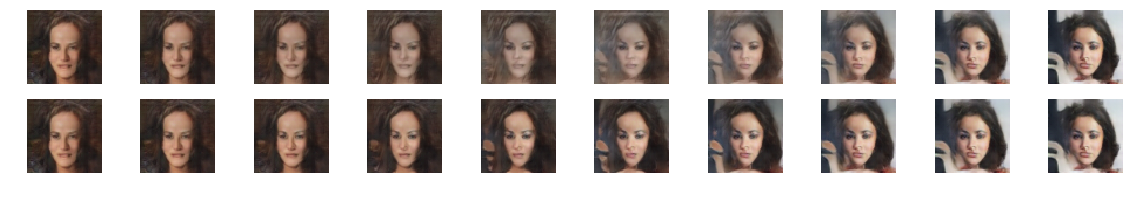

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(20, 3))

for index, item in enumerate(draw_interpolation(rand, rand2, do_scale=False)):
    #print(item)
    interpolated = netG.main(item)
    #print((interpolated + 1) /2 )
    plot_torch_picture(interpolated, ax=ax[0, index])

for index, item in enumerate(draw_interpolation(rand, rand2)):
    #print(item)
    interpolated = netG.main(item)
    #print((interpolated + 1) / 2)
    plot_torch_picture(interpolated, ax=ax[1, index])
    
plt.show()

In [10]:
eps = 0.5

rand_shifted_no_scale = vicinity_sampling(rand, torch.zeros_like(rand), eps=eps, do_scale=False)
rand_shifted = vicinity_sampling(rand, torch.zeros_like(rand), eps=eps)

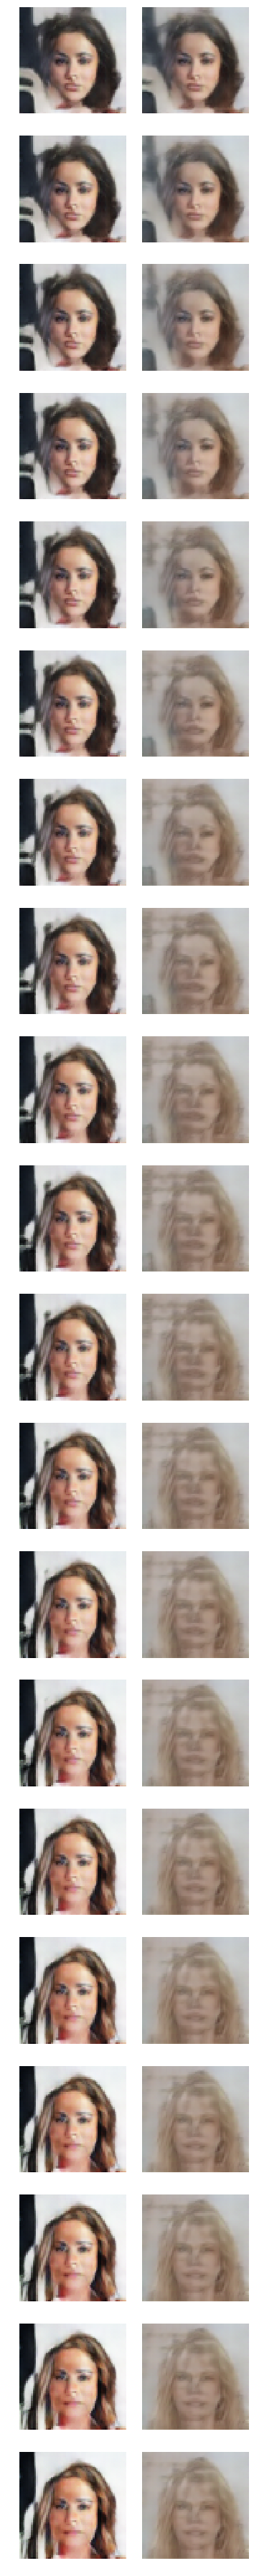

In [11]:
fig, ax = plt.subplots(nrows=20, ncols=2, figsize=(5, 50))
for i in range(20):
    shift = torch.rand_like(rand_shifted) + 0.5
    shift /= torch.norm(shift)
   # print(rand_shifted_no_scale.flatten())
   # print(rand_shifted.flatten())
    rand_shifted_no_scale = vicinity_sampling(rand_shifted_no_scale, shift, eps=eps, do_scale=False)
    rand_shifted = vicinity_sampling(rand_shifted, shift, eps=eps)
    plot_torch_picture(netG.main(rand_shifted_no_scale), ax=ax[i][0])
    plot_torch_picture(netG.main(rand_shifted), ax=ax[i][1])
plt.axis('off')
plt.tight_layout()
plt.show()

tensor(56.2024, grad_fn=<NormBackward0>)
output 1 min:-0.9561124444007874, max:0.9821431636810303
output 2 min:-0.777672290802002, max:0.9005547761917114


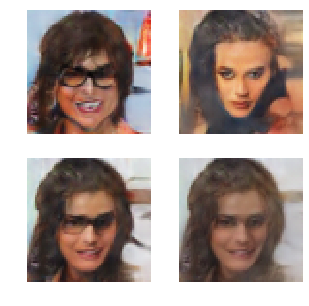

In [12]:
t = 0.5


rand1 = torch.randn(1, 100, 1, 1, device='cpu')
rand2 = torch.randn(1, 100, 1, 1, device='cpu')
interpolation = two_point_interpolation(rand1, rand2, t=t)
interpolation_no_scale = two_point_interpolation(rand1, rand2, do_scale=False, t=t)

output1 = netG.main(rand1)
output2 = netG.main(rand2)

print(torch.norm(output1 - output2))

print('output 1 min:{}, max:{}'.format(output1.min(), output1.max()))
print('output 2 min:{}, max:{}'.format(output2.min(), output2.max()))

fig, ax = plt.subplots(2, 2, figsize=(5,5))


plot_torch_picture(output1, ax[0, 0])
plot_torch_picture(output2, ax[0, 1])
plot_torch_picture(netG.main(interpolation), ax[1, 0])
plot_torch_picture(netG.main(interpolation_no_scale), ax[1, 1])

In [13]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs

    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)



In [14]:
t = 0.5
src_set  = [torch.randn(1, 100, 1, 1, device='cpu') for _ in range(30)]
dst_set  = [torch.randn(1, 100, 1, 1, device='cpu') for _ in range(30)]
pair_set = [two_point_interpolation(src, dst, t=t) for src,dst in zip(src_set, dst_set)]
output_pair = [netG.main(item) for item in pair_set]
print(inception_score(torch.cat(output_pair), cuda=False, batch_size=2, resize=True, splits=10))

/home/nekrald/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/nekrald/.local/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/nekrald/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(1.5390615357134876, 0.14827275296689732)
